In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

training_df = pd.read_csv('phase1_training_data.csv')
training_df.head()

,country_id,date,cases,deaths,cases_14_100k,cases_100k
0,AD,12/31/2019,0,0,0.0,0.0
1,AD,1/1/2020,0,0,0.0,0.0
2,AD,1/2/2020,0,0,0.0,0.0
3,AD,1/3/2020,0,0,0.0,0.0
4,AD,1/4/2020,0,0,0.0,0.0


In [2]:
training_df.shape

(58520, 6)

In [3]:
training_df['date'] = training_df['date'].astype('datetime64')

In [4]:
missing_rows = training_df['country_id'].isna()
print(sum(missing_rows))
print(len(training_df[missing_rows]['date'].unique()))

280
280


In [5]:
training_df['country_id'].fillna('Unknown', inplace=True)

In [6]:
training_df['country_id'].value_counts()

MG         280
Unknown    280
KW         280
UA         280
MZ         280
          ... 
MD         280
BM         280
TC         280
US         280
BR         280
Name: country_id, Length: 209, dtype: int64

In [7]:
training_df['country_id'].unique().shape

(209,)

#### Apparently, one country is missing. Also, we have 280 rows for each country.
## Let's sort the dataframe based on date and compute non-commulative values

In [8]:
training_df.sort_values(['country_id', 'date'], inplace=True)
training_df

,country_id,date,cases,deaths,cases_14_100k,cases_100k
0,AD,2019-12-31,0,0,0.00,0.00
1,AD,2020-01-01,0,0,0.00,0.00
2,AD,2020-01-02,0,0,0.00,0.00
3,AD,2020-01-03,0,0,0.00,0.00
4,AD,2020-01-04,0,0,0.00,0.00
...,...,...,...,...,...,...
58515,ZW,2020-10-01,7838,228,1.40,53.52
58516,ZW,2020-10-02,7850,228,1.39,53.60
58517,ZW,2020-10-03,7858,228,1.27,53.65
58518,ZW,2020-10-04,7885,228,1.38,53.84


In [9]:
def filter_by_country(country_id):
    return training_df[training_df['country_id'] == country_id]

In [10]:
for col in training_df.columns[2:]:
    training_df[col+'_daily'] = training_df.groupby('country_id')[col].transform(lambda x: x.diff().fillna(0))
    
training_df

,country_id,date,cases,deaths,cases_14_100k,cases_100k,cases_daily,deaths_daily,cases_14_100k_daily,cases_100k_daily
0,AD,2019-12-31,0,0,0.00,0.00,0,0,0.00,0.00
1,AD,2020-01-01,0,0,0.00,0.00,0,0,0.00,0.00
2,AD,2020-01-02,0,0,0.00,0.00,0,0,0.00,0.00
3,AD,2020-01-03,0,0,0.00,0.00,0,0,0.00,0.00
4,AD,2020-01-04,0,0,0.00,0.00,0,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
58515,ZW,2020-10-01,7838,228,1.40,53.52,1,0,-0.23,0.01
58516,ZW,2020-10-02,7850,228,1.39,53.60,12,0,-0.01,0.08
58517,ZW,2020-10-03,7858,228,1.27,53.65,8,0,-0.12,0.05
58518,ZW,2020-10-04,7885,228,1.38,53.84,27,0,0.11,0.19


## Now let's calculate the correlation between each feature, country-wise

In [11]:
grouped = training_df.groupby('country_id')
country_ids = list(grouped.groups.keys())

cols = training_df.columns[2:]
idx = pd.MultiIndex.from_product([cols, country_ids], names=['feature', 'country_id'])
corrs_df = pd.DataFrame(np.zeros((len(cols) * len(country_ids), len(country_ids))), index=idx, columns=country_ids)
corrs_df

for col in training_df.columns[2:]:
    for c1 in country_ids:
        for c2 in country_ids:
            correlation = np.corrcoef(grouped.get_group(c1)[col], grouped.get_group(c2)[col])[0, 1]
            corrs_df.loc[col, c1][c2] = correlation

/Users/hezardastan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/hezardastan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [12]:
corrs_df

AD        AE        AF        AG        AI  \
feature          country_id                                                     
cases            AD          1.000000  0.917681  0.831371  0.874861  0.841968   
                 AE          0.917681  1.000000  0.973524  0.959828  0.700529   
                 AF          0.831371  0.973524  1.000000  0.953035  0.670003   
                 AG          0.874861  0.959828  0.953035  1.000000  0.705033   
                 AI          0.841968  0.700529  0.670003  0.705033  1.000000   
...                               ...       ...       ...       ...       ...   
cases_100k_daily XK          0.003130  0.153635 -0.006044  0.094893 -0.044248   
                 YE         -0.094161  0.229061  0.569005  0.059603 -0.043681   
                 ZA         -0.106224  0.148440  0.172610  0.110476 -0.050242   
                 ZM          0.026582  0.154297 -0.081329  0.006590 -0.040087   
                 ZW          0.030974  0.065861 -0.061636  0.015386 -0.039028   

                                   AL        AM        AO        AR        AT  \
feature          country_id                                                     
cases            AD          0.857600  0.848304  0.808328  0.816856  0.995196   
                 AE          0.916479  0.978103  0.837656  0.853182  0.926733   
                 AF          0.843398  0.977276  0.734337  0.755148  0.838904   
                 AG          0.902667  0.978664  0.808548  0.823876  0.893209   
                 AI          0.513863  0.616557  0.402555  0.417149  0.813268   
...                               ...       ...       ...       ...       ...   
cases_100k_daily XK          0.642379  0.351107  0.352001  0.455844  0.070394   
                 YE          0.155514  0.573882 -0.004050  0.009002 -0.179561   
                 ZA          0.484833  0.597372  0.246283  0.292418 -0.067142   
                 ZM          0.544584  0.178116  0.413191  0.470631  0.145058   
                 ZW          0.550223  0.167191  0.234714  0.381147  0.083258   

                             ...        VC        VE        VG        VI  \
feature          country_id  ...                                           
cases            AD          ...  0.901450  0.806116  0.802957  0.803826   
                 AE          ...  0.975864  0.850475  0.779299  0.856627   
                 AF          ...  0.951946  0.756537  0.651867  0.773571   
                 AG          ...  0.974266  0.826472  0.713240  0.849809   
                 AI          ...  0.717320  0.415423  0.426456  0.454254   
...                          ...       ...       ...       ...       ...   
cases_100k_daily XK          ...  0.134114  0.512654  0.115227  0.445904   
                 YE          ...  0.181334  0.018247 -0.032103  0.028915   
                 ZA          ...  0.247980  0.313510 -0.017214  0.306218   
                 ZM          ...  0.097782  0.485094  0.111468  0.482205   
                 ZW          ...  0.086720  0.479111  0.188381  0.352177   

                                   VN        XK        YE        ZA        ZM  \
feature          country_id                                                     
cases            AD          0.897670  0.825088  0.817953  0.793618  0.806967   
                 AE          0.919539  0.915538  0.966612  0.919592  0.879859   
                 AF          0.856575  0.863900  0.978819  0.895895  0.807249   
                 AG          0.921805  0.925107  0.972965  0.946851  0.870650   
                 AI          0.675169  0.512319  0.595101  0.510155  0.459613   
...                               ...       ...       ...       ...       ...   
cases_100k_daily XK          0.395574  1.000000  0.284869  0.725761  0.577878   
                 YE          0.005742  0.284869  1.000000  0.446851  0.045892   
                 ZA          0.288351  0.725761  0.446851  1.000000  0.470382   
                 ZM          0.420465  0.577878

In [13]:
corrs_df.to_csv('feature_correlation_country_wise.csv')

# Let's move to the next step, testing if features are stationary

In [12]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue': round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']

    def adjust(val, length= 6): 
        return str(val).ljust(length)

    # Print Summary
    print(f'Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Significance Level = {signif}')
    print(f'Test Statistic = {output["test_statistic"]}')
    print(f'No. Lags Chosen = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')
        if p_value <= signif:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.")

In [13]:
for name, column in list(training_df.iteritems())[2:]:
    adfuller_test(column, name=column.name)
    print('\n\n')

Augmented Dickey-Fuller Test on "cases" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -18.4016
No. Lags Chosen = 1
 Critical value 1%     = -3.43
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.862
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



Augmented Dickey-Fuller Test on "deaths" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -15.2575
No. Lags Chosen = 8
 Critical value 1%     = -3.43
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.862
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 10%    = -2.567
 => P-Valu

In [14]:
for name, column in list(training_df.iteritems())[2:]:
    adfuller_test(column, name=column.name, signif=0.01)
    print('\n\n')

Augmented Dickey-Fuller Test on "cases" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.01
Test Statistic = -18.4016
No. Lags Chosen = 1
 Critical value 1%     = -3.43
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.862
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



Augmented Dickey-Fuller Test on "deaths" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.01
Test Statistic = -15.2575
No. Lags Chosen = 8
 Critical value 1%     = -3.43
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.862
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 10%    = -2.567
 => P-Valu

KeyboardInterrupt: 

In [ ]:
# Generate random residuals
np.random.seed(0)
errors = np.random.normal(0, 1, 1000)

# Create AR(1) samples for models with and without unit roots
x_unit_root = [0]
x_no_unit_root = [0]
for i in range(len(errors)):
    x_unit_root.append(x_unit_root[-1] + errors[i])
    x_no_unit_root.append(0.9*x_no_unit_root[-1] + errors[i])
                          
adfuller_test(x_unit_root, name='Unit root', signif=0.01)
adfuller_test(x_no_unit_root, name='No Unit root', signif=0.01)

## So we have no problem and all of the features seem to be appropriate without any required transformation!
## Let's train a simple OLS model on `deaths_daily ~ cases_daily`

In [15]:
ca_train_df = filter_by_country('CA')[filter_by_country('CA')['date'] >= '2020-03-15']
ca_train_df

,country_id,date,cases,deaths,cases_14_100k,cases_100k,cases_daily,deaths_daily,cases_14_100k_daily,cases_100k_daily
9035,CA,2020-03-15,244,1,0.59,0.65,68,0,0.17,0.18
9036,CA,2020-03-16,304,1,0.74,0.81,60,0,0.15,0.16
9037,CA,2020-03-17,424,4,1.05,1.13,120,3,0.31,0.32
9038,CA,2020-03-18,569,8,1.43,1.52,145,4,0.38,0.39
9039,CA,2020-03-19,690,9,1.72,1.84,121,1,0.29,0.32
...,...,...,...,...,...,...,...,...,...,...
9235,CA,2020-10-01,158758,9297,47.82,424.36,1797,6,1.81,4.80
9236,CA,2020-10-02,160535,9319,49.78,429.11,1777,22,1.96,4.75
9237,CA,2020-10-03,162659,9409,53.15,434.79,2124,90,3.37,5.68
9238,CA,2020-10-04,164471,9462,55.66,439.63,1812,53,2.51,4.84


In [16]:
import statsmodels.formula.api as smf

formula = 'deaths_daily ~ cases_daily'
results = smf.ols(formula, ca_train_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           deaths_daily   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     114.0
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           2.09e-21
Time:                        18:12:11   Log-Likelihood:                -1072.5
No. Observations:                 205   AIC:                             2149.
Df Residuals:                     203   BIC:                             2156.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.3937      5.709     -0.770      

<AxesSubplot:xlabel='date', ylabel='cases_daily'>

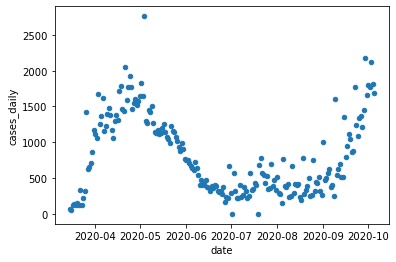

In [17]:
ca_train_df.plot.scatter(x='date', y='cases_daily')

<AxesSubplot:xlabel='date', ylabel='deaths_daily'>

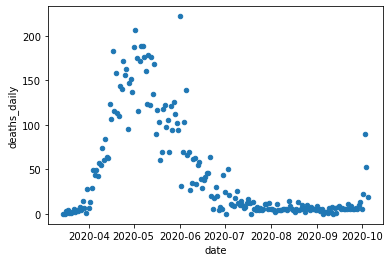

In [18]:
ca_train_df.plot.scatter(x='date', y='deaths_daily')

<AxesSubplot:xlabel='cases_daily', ylabel='deaths_daily'>

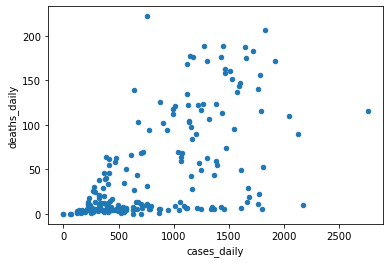

In [19]:
ca_train_df.plot.scatter(x='cases_daily', y='deaths_daily')

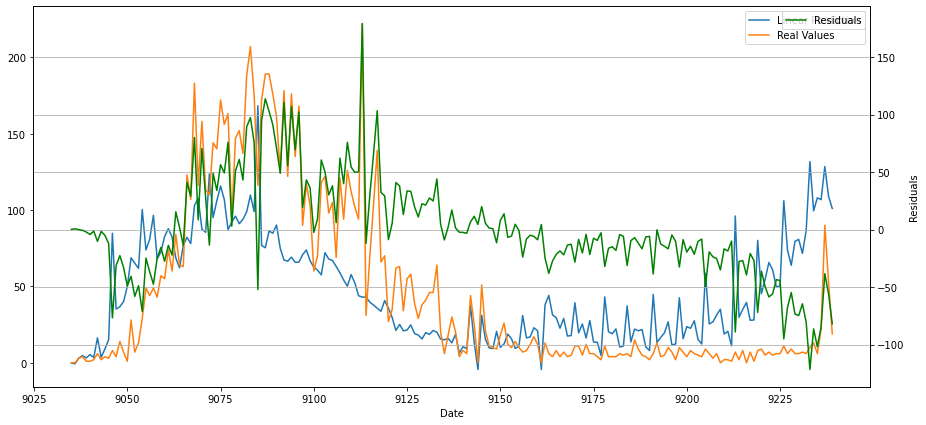

In [20]:
residuals = results.resid
deaths_fit = results.fittedvalues

fig = plt.figure(1, figsize=(15, 7))
ax1 = fig.add_subplot(111)
ax1.plot(deaths_fit, label='Linear Prediction')
ax1.plot(ca_train_df['deaths_daily'], label='Real Values')
ax1.set_xlabel('Date')
ax1.legend(loc=0)
ax2 = plt.twinx()
ax2.set_ylabel('Residuals')
ax2.plot(residuals, label='Residuals', color='green')
ax2.legend(loc=0)
plt.grid(True)
plt.show()

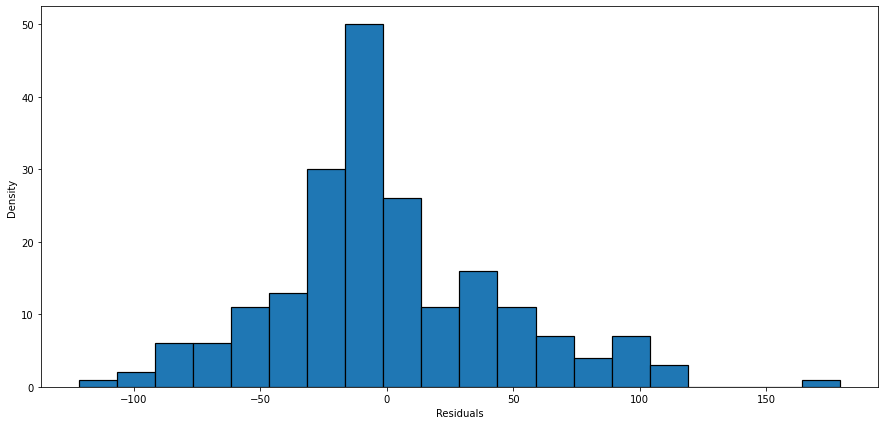

In [21]:
plt.figure(1, figsize=(15, 7))
plt.hist(residuals, 20, edgecolor='black', linewidth=1.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Let's move on to VAR

In [75]:
ca_train_df.loc[:, ['cases', 'deaths', 'cases_daily']]

,cases,deaths,cases_daily
9035,244,1,68
9036,304,1,60
9037,424,4,120
9038,569,8,145
9039,690,9,121
...,...,...,...
9235,158758,9297,1797
9236,160535,9319,1777
9237,162659,9409,2124
9238,164471,9462,1812


In [44]:
import statsmodels.tsa.api as smt

var_model = smt.VAR(ca_train_df.loc[:, ['cases_daily', 'deaths_daily']])
res = var_model.select_order(maxlags=20)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        20.27       20.31   6.377e+08       20.29
1        18.00       18.11   6.599e+07       18.05
2        17.66       17.84   4.678e+07       17.73
3        17.47       17.72   3.878e+07       17.57
4        17.31      17.62*   3.282e+07      17.43*
5        17.33       17.71   3.358e+07       17.48
6        17.31       17.76   3.295e+07       17.49
7       17.27*       17.79  3.165e+07*       17.48
8        17.30       17.89   3.260e+07       17.54
9        17.34       18.00   3.384e+07       17.60
10       17.35       18.08   3.440e+07       17.65
11       17.36       18.16   3.474e+07       17.69
12       17.39       18.26   3.590e+07       17.75
13       17.41       18.35   3.658e+07       17.79
14       17.39       18.40   3.583e+07       17.80
15       17.40       18.48   3.643e+07       17.84
16       17.41       18.56   3.

/Users/hezardastan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [45]:
#Fit VAR model
var_model = smt.VAR(endog=ca_train_df.loc[:, ['cases_daily', 'deaths_daily']])
var_model_fit = var_model.fit(maxlags=20)
#Print a summary of the model results
var_model_fit.summary()

/Users/hezardastan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 30, Nov, 2020
Time:                     20:08:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    18.9305
Nobs:                     185.000    HQIC:                   18.0816
Log likelihood:          -2062.04    FPE:                4.05508e+07
AIC:                      17.5031    Det(Omega_mle):     2.71723e+07
--------------------------------------------------------------------
Results for equation cases_daily
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                  -18.957784        49.662847           -0.382           0.703
L1.cases_daily           0.116136         0.082413            1.409           0.159
L1.deaths_daily          0.720676         

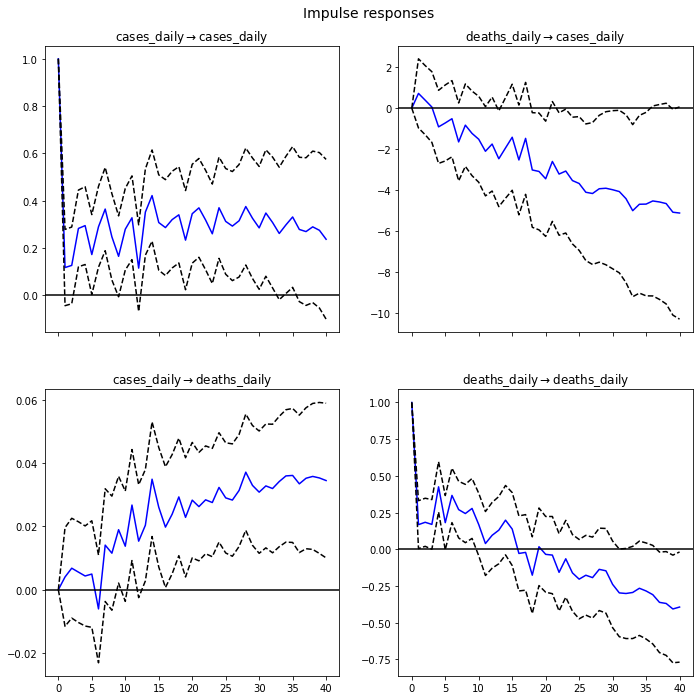

In [46]:
# Impulse Response Analysis
irf = var_model_fit.irf(40)
irf.plot()
plt.show()

/Users/hezardastan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


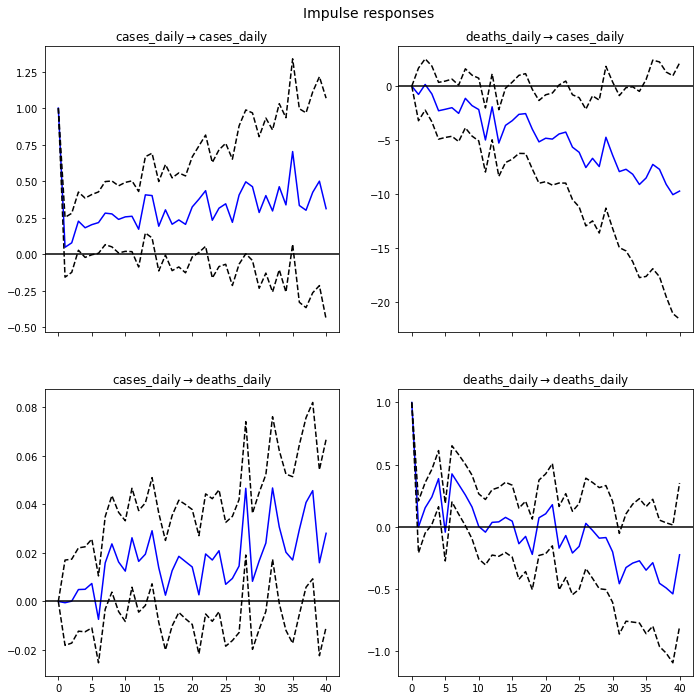

In [79]:
#Fit VAR model
var_model = smt.VAR(endog=ca_train_df.loc[:, ['cases_daily', 'deaths_daily']])
var_model_fit = var_model.fit(maxlags=40)
#Print a summary of the model results
irf = var_model_fit.irf(40)
irf.plot()
plt.show()

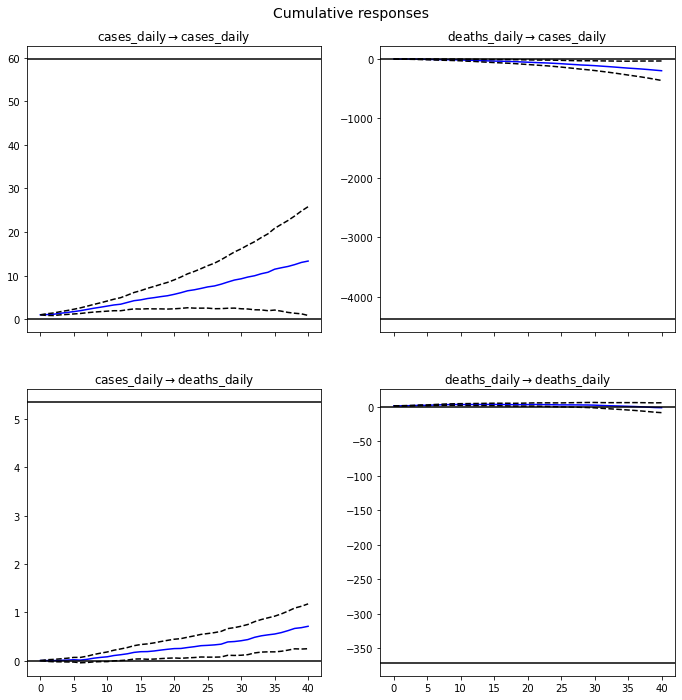

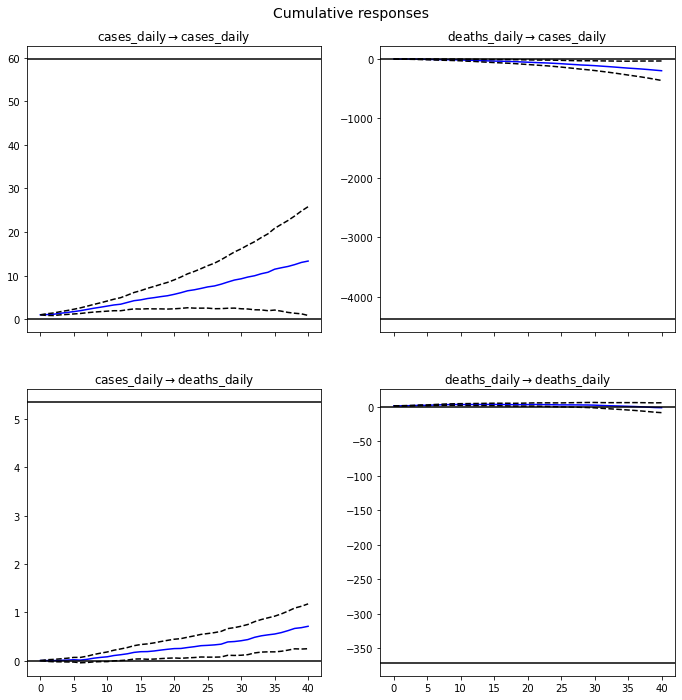

In [62]:
irf.plot_cum_effects()

In [47]:
var_model = smt.VAR(endog=ca_train_df.loc[:, ['cases_daily', 'deaths_daily']])
var_model_fit = var_model.fit(maxlags=10)

/Users/hezardastan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


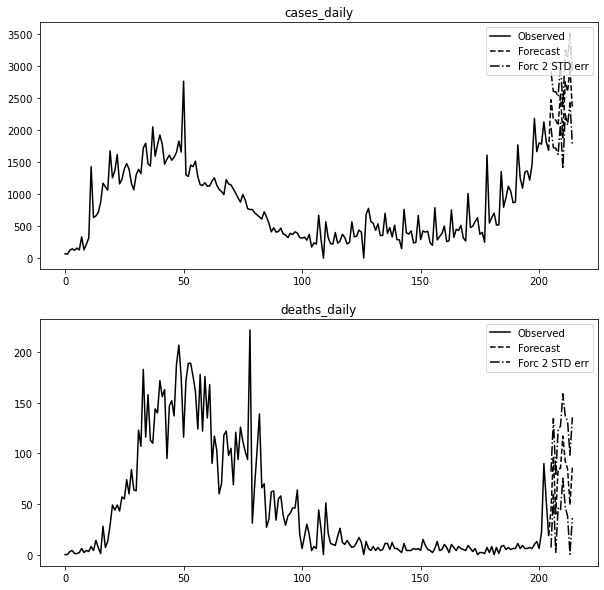

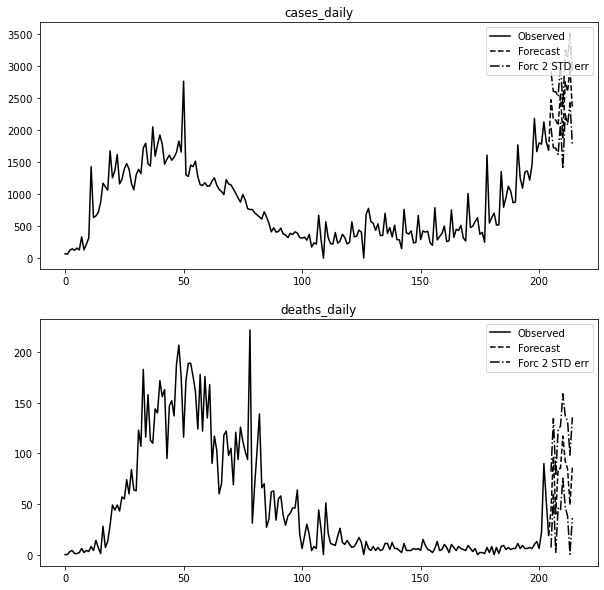

In [61]:
var_model_fit.plot_forecast(10)

In [86]:
# Get the lag order
lag_order = var_model_fit.k_ar
# Input data for forecasting
input_data = ca_train_df.loc[:, ['cases_daily', 'deaths_daily']].values[-lag_order:]
# forecasting
pred = var_model_fit.forecast(y=input_data, steps=ca_train_df.shape[0])
pred = (pd.DataFrame(pred, index=ca_train_df.loc[:, ['cases_daily', 'deaths_daily']].index, columns= [c + '_pred' for c in ['cases_daily', 'deaths_daily']]))

In [87]:
# inverting transformation
def invert_transformation(df_tr_diff, pred):
    forecast = pred.copy()
    columns = ['cases_daily', 'deaths_daily']
    for col in columns:
        forecast[str(col)+'_pred'] = ca_train_df[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast

output = invert_transformation(ca_train_df.loc[:, ['cases_daily', 'deaths_daily']], pred)
output.loc[:, ['deaths_daily_pred']]

,deaths_daily_pred
9035,80.078718
9036,158.220852
9037,240.011634
9038,326.650909
9039,431.164055
...,...
9235,19176.147517
9236,19250.692764
9237,19323.624477
9238,19394.970631


In [88]:
eval_df = ca_train_df.loc[:, ['cases_daily', 'deaths_daily']]
eval_df['cases_daily_pred'] = output['cases_daily_pred']
eval_df['deaths_daily_pred'] = output['deaths_daily_pred']
eval_df

,cases_daily,deaths_daily,cases_daily_pred,deaths_daily_pred
9035,68,0,3838.138307,80.078718
9036,60,0,5901.501143,158.220852
9037,120,3,7837.372528,240.011634
9038,145,4,9984.044514,326.650909
9039,121,1,12176.284638,431.164055
...,...,...,...,...
9235,1797,6,236292.623249,19176.147517
9236,1777,22,237092.931186,19250.692764
9237,2124,90,237884.489479,19323.624477
9238,1812,53,238667.902104,19394.970631


In [89]:
print(1)

1


In [100]:
#Fit VAR model
var_model = smt.VAR(endog=ca_train_df.loc[:, ['cases', 'deaths']].values)
var_model_fit = var_model.fit(maxlags=8)
#Print a summary of the model results
var_model_fit.summary()

# Get the lag order
lag_order = var_model_fit.k_ar
# Input data for forecasting
input_data = ca_train_df.loc[:, ['cases', 'deaths']].values[-lag_order:]
# forecasting
pred = var_model_fit.forecast(y=input_data, steps=ca_train_df.shape[0])
pred = (pd.DataFrame(pred, index=ca_train_df.loc[:, ['cases', 'deaths']].index, columns= [c + '_pred' for c in ['cases', 'deaths']]))

def invert_transformation(df_tr_diff, pred):
    forecast = pred.copy()
    columns = ['cases', 'deaths']
    for col in columns:
        forecast[str(col)+'_pred'] = ca_train_df[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast

output = invert_transformation(ca_train_df.loc[:, ['cases', 'deaths']], pred)
output.loc[:, ['deaths_pred']]

eval_df = ca_train_df.loc[:, ['cases', 'deaths']]
eval_df['cases_pred'] = output['cases_pred']
eval_df['deaths_pred'] = output['deaths_pred']
eval_df

,cases,deaths,cases_pred,deaths_pred
9035,244,1,3.343826e+05,1.901662e+04
9036,304,1,5.045724e+05,2.861445e+04
9037,424,4,6.767123e+05,3.827502e+04
9038,569,8,8.509708e+05,4.800193e+04
9039,690,9,1.027400e+06,5.780738e+04
...,...,...,...,...
9235,158758,9297,1.447351e+08,6.834998e+06
9236,160535,9319,1.466977e+08,6.922661e+06
9237,162659,9409,1.486855e+08,7.011413e+06
9238,164471,9462,1.506989e+08,7.101268e+06


# Load validation data

In [23]:
validation_df_ca = pd.read_csv('phase_1_answer.csv')
validation_df_ca

,country_id,date,cases,deaths,cases_14_100k,cases_100k
0,CA,2020-10-06,168960,9504,59.60,451.63
1,CA,2020-10-07,171323,9530,63.00,457.95
2,CA,2020-10-08,173123,9541,64.23,462.76
3,CA,2020-10-09,175559,9557,67.10,469.27
4,CA,2020-10-10,178117,9585,70.69,476.11
5,CA,2020-10-11,178117,9585,66.80,476.11
6,CA,2020-10-12,178117,9585,60.99,476.11
7,CA,2020-10-13,182839,9627,69.17,488.73
8,CA,2020-10-14,186881,9654,75.17,499.53
9,CA,2020-10-15,189387,9664,77.12,506.23


In [24]:
second_val_df = pd.read_csv('general_phase_1_answer.csv')
second_val_df = second_val_df[second_val_df['country_id'] == 'CA']

In [25]:
def save_results(y_pred, file_name):
    y = range(0, y_pred.shape[0])
    out = np.append(np.transpose([y_pred]), np.transpose([y]), axis=1)
    np.savetxt(file_name, out, delimiter=',',fmt=['%d', '%d'], header='deaths,Id', comments='')

# Let's try the AutoReg model! :(

<AxesSubplot:xlabel='lag'>

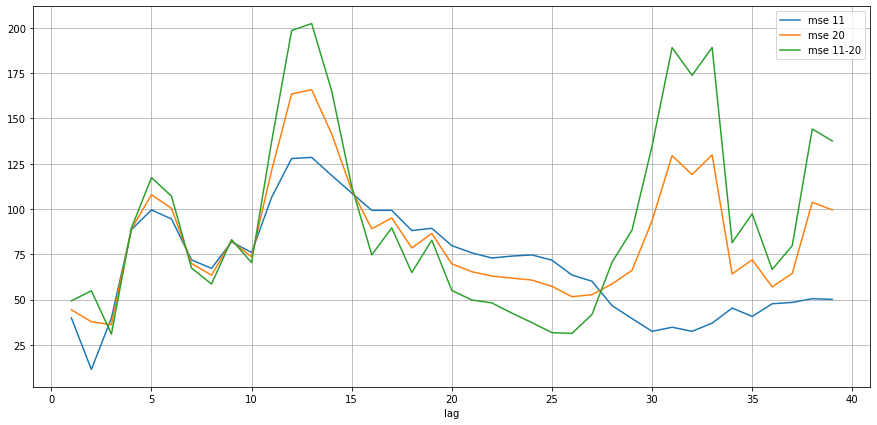

In [26]:
import statsmodels.tsa.ar_model as sma

errs = []
for lag in range(1, 40):    
    res = sma.AutoReg(ca_train_df['deaths'].values, lags=lag, old_names=False).fit()
    predictions = pd.DataFrame({
        "deaths": validation_df_ca['deaths'].values, 
        "deaths_pred": res.predict(205, 205+10)
    })
    err1 = np.sqrt(np.mean((predictions['deaths'] - predictions['deaths_pred']).values ** 2))
    err2 = np.sqrt(np.mean((res.predict(205, 205+19) - second_val_df['deaths'].values) ** 2))
    err3 = np.sqrt(np.mean((res.predict(205+11, 205+19) - second_val_df['deaths'].values[-9:]) ** 2))
    errs.append((lag, err1, err2, err3))
    
pd.DataFrame(errs, columns=['lag', 'mse 11', 'mse 20', 'mse 11-20']).plot\
    .line(x='lag', y=['mse 11', 'mse 20', 'mse 11-20'], figsize=(15, 7), grid=True)

In [69]:
res = sma.AutoReg(ca_train_df['deaths'].values, lags=3, old_names=False).fit()

In [70]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  205
Model:                     AutoReg(3)   Log Likelihood                -927.772
Method:               Conditional MLE   S.D. of innovations             23.903
Date:                Mon, 30 Nov 2020   AIC                              6.397
Time:                        21:04:01   BIC                              6.479
Sample:                             3   HQIC                             6.431
                                  205                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8409      4.801      2.883      0.004       4.430      23.251
y.L1           1.4492      0.063     23.036      0.000       1.326       1.572
y.L2          -0.0045      0.120     -0.038      0.970      -0.240       0.231
y.L3          -0.4460      0.062     -7.192      0.000      -0.568      -0.324
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0172           +0.0000j            1.0172            0.0000
AR.2            1.0574           +0.0000j            1.0574            0.0000
AR.3           -2.0847           +0.0000j            2.0847            0.5000
-----------------------------------------------------------------------------
"""

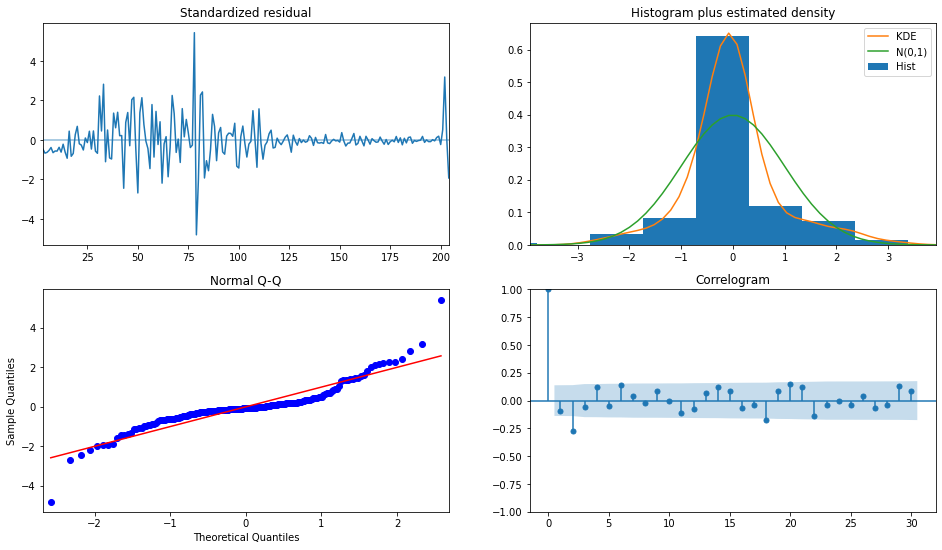

In [71]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=30)

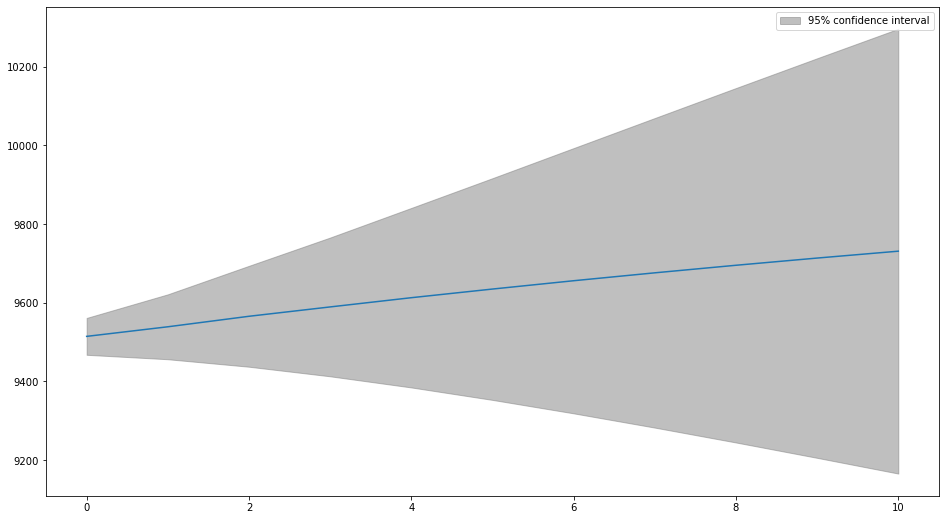

In [72]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_predict(205, 205+10, fig=fig)

In [27]:
from sklearn.metrics import mean_squared_error

lag = 40
data = ca_train_df['deaths'].values
res = sma.AutoReg(data, lags=lag, old_names=False).fit()
predictions = pd.DataFrame({
    "deaths": data[-10:], 
    "deaths_pred": res.predict(len(data)-9, len(data))
})
# print(predictions)
print('MSE:', np.mean((predictions['deaths'] - predictions['deaths_pred']).values ** 2))
mean_squared_error(predictions['deaths'], predictions['deaths_pred'])

MSE: 143.028563167252


143.028563167252

In [28]:
ca_train_df['deaths']

9035       1
9036       1
9037       4
9038       8
9039       9
        ... 
9235    9297
9236    9319
9237    9409
9238    9462
9239    9481
Name: deaths, Length: 205, dtype: int64

In [275]:
# res.predict(len(data)-3,len(data)+7)

array([9325.33101677, 9422.06146328, 9478.57088491, 9507.11096341,
       9553.13767797, 9580.02903734, 9612.36279821, 9632.60522375,
       9649.55730518, 9663.77383853, 9666.38628766])

In [273]:
def save_results(y_pred, file_name):
    y = range(0, y_pred.shape[0])
    out = np.append(np.transpose([y_pred]), np.transpose([y]), axis=1)
    np.savetxt(file_name, out, delimiter=',',fmt=['%d', '%d'], header='deaths,Id', comments='')

In [278]:
save_results(res.predict(len(data)-1,len(data)+9), 'test4.csv')

In [279]:
# Let's try AutoReg with daily data

In [303]:
def get_commu_result(start, end):
    return ca_train_df['deaths'].values[start-1] + np.cumsum(res.predict(start, end))

In [310]:
from sklearn.metrics import mean_squared_error

lag = 3
data = ca_train_df['deaths_daily'].values
res = sma.AutoReg(data, lags=lag, old_names=False).fit()
predictions = pd.DataFrame({
    "deaths_daily": data[-10:], 
    "deaths_daily_pred": res.predict(len(data)-9, len(data)),
    "deaths": ca_train_df['deaths'].values[-10:],
    "deaths_pred": get_commu_result(len(data)-9, len(data))
})
print(predictions)
print('MSE:', np.mean((predictions['deaths'] - predictions['deaths_pred']).values ** 2))
mean_squared_error(predictions['deaths'], predictions['deaths_pred'])

   deaths_daily  deaths_daily_pred  deaths  deaths_pred
0             6           9.224501    9255  9264.224501
1             7           8.962742    9262  9273.187243
2             6           8.942000    9268  9282.129243
3            10          10.304374    9278  9292.433617
4            13          12.642908    9291  9305.076525
5             6          11.926189    9297  9317.002714
6            22          16.096280    9319  9333.098994
7            90          45.885907    9409  9378.984901
8            53          59.544189    9462  9438.529090
9            19          48.056357    9481  9486.585447
MSE: 289.82363482194353


289.82363482194353

In [315]:
save_results(get_commu_result(len(data)-2,len(data)+8), 'test5.csv')

In [313]:
get_commu_result(len(data)-2,len(data)+8)

array([9454.88590705, 9514.43009611, 9562.48645273, 9601.5181416 ,
       9640.25384622, 9681.84927047, 9722.49614071, 9763.73993779,
       9805.47932361, 9847.41570762, 9889.72940247])

No handles with labels found to put in legend.


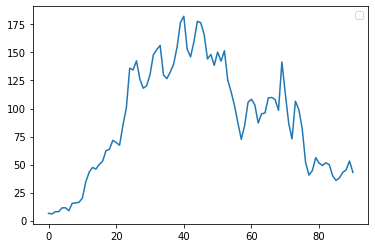

In [494]:
a = np.array([1, 2, 3])

In [500]:
np.append(1, a)

array([1, 1, 2, 3])

In [499]:
second_val_df

,country_id,date,cases,deaths,cases_14_100k,cases_100k
640,CA,2020-10-06,168960,9504,59.60,451.63
641,CA,2020-10-07,171323,9530,63.00,457.95
642,CA,2020-10-08,173123,9541,64.23,462.76
643,CA,2020-10-09,175559,9557,67.10,469.27
644,CA,2020-10-10,178117,9585,70.69,476.11
645,CA,2020-10-11,178117,9585,66.80,476.11
646,CA,2020-10-12,178117,9585,60.99,476.11
647,CA,2020-10-13,182839,9627,69.17,488.73
648,CA,2020-10-14,186881,9654,75.17,499.53
649,CA,2020-10-15,189387,9664,77.12,506.23
